<a href="https://colab.research.google.com/github/TheUnmeshRaj/ANN-4D-Gaussian/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://drive.google.com/file/d/1eluTlXg0ARror0aIf0-T2DikUENzaMp9/view?usp=sharing

Loaded points: (11766, 3)
Gaussians initialized: 11766
Using device: cpu
Plotted points: 11766


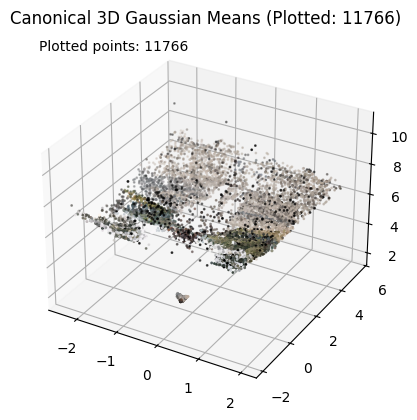

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import numpy as np

BASE_DIR = os.path.dirname(".")
POINTS_PATH = os.path.join(BASE_DIR, "points3D.txt")


def load_colmap_points(path):
    points = []
    colors = []

    with open(path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue

            elems = line.strip().split()
            x, y, z = map(float, elems[1:4])
            r, g, b = map(int, elems[4:7])

            points.append([x, y, z])
            colors.append([r, g, b])

    return np.array(points), np.array(colors) / 255.0


points, colors = load_colmap_points(POINTS_PATH)
print("Loaded points:", points.shape)

def initialize_gaussians(points, colors):
    N = points.shape[0]

    means = points                          # μ
    covariances = np.array([
        np.eye(3) * 0.01 for _ in range(N)  # Σ (small isotropic)
    ])

    opacities = np.ones((N, 1)) * 0.1        # α
    colors_rgb = colors                      # c

    return means, covariances, opacities, colors_rgb


means, covs, alphas, cols = initialize_gaussians(points, colors)

print("Gaussians initialized:", means.shape[0])
import torch

device = "cpu"

means_t = torch.tensor(means, dtype=torch.float32, device=device)
covs_t = torch.tensor(covs, dtype=torch.float32, device=device)
alphas_t = torch.tensor(alphas, dtype=torch.float32, device=device)
colors_t = torch.tensor(cols, dtype=torch.float32, device=device)

print("Using device:", device)
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    means[:, 0],
    means[:, 1],
    means[:, 2],
    c=cols,
    s=1
)

# Counter: how many points were actually plotted
plotted_count = means.shape[0]
print("Plotted points:", plotted_count)
# Show count on the figure (2D overlay so it appears on the canvas)
ax.set_title(f"Canonical 3D Gaussian Means (Plotted: {plotted_count})")
ax.text2D(0.05, 0.95, f"Plotted points: {plotted_count}", transform=ax.transAxes, fontsize=10, color="black")

plt.show()


Loading COLMAP points...
Number of Gaussians: 11766
Loading camera pose...
Projecting points...
Rendering image using Gaussian splatting...


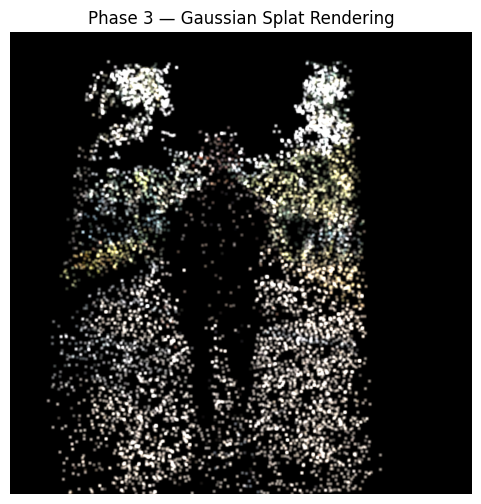

In [5]:
# scripts/phase3_render.py

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Resolve project root
# --------------------------------------------------
BASE_DIR = os.path.dirname(".")

IMAGES_PATH = os.path.join(BASE_DIR, "images.txt")
POINTS_PATH = os.path.join(BASE_DIR, "points3D.txt")

IMAGE_SIZE = (800, 800)   # (H, W)
FOCAL_LENGTH = 1000       # simple pinhole assumption


# --------------------------------------------------
# STEP 3.1 — Load first camera pose from COLMAP
# --------------------------------------------------
def load_first_camera_pose(images_path):
    with open(images_path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue

            elems = line.strip().split()
            qw, qx, qy, qz = map(float, elems[1:5])
            tx, ty, tz = map(float, elems[5:8])

            q = np.array([qw, qx, qy, qz])
            t = np.array([tx, ty, tz])

            return q, t


# --------------------------------------------------
# STEP 3.2 — Quaternion → Rotation Matrix
# --------------------------------------------------
def quat_to_rotmat(q):
    qw, qx, qy, qz = q

    R = np.array([
        [1 - 2*(qy*qy + qz*qz),     2*(qx*qy - qz*qw),     2*(qx*qz + qy*qw)],
        [2*(qx*qy + qz*qw),         1 - 2*(qx*qx + qz*qz), 2*(qy*qz - qx*qw)],
        [2*(qx*qz - qy*qw),         2*(qy*qz + qx*qw),     1 - 2*(qx*qx + qy*qy)]
    ])

    return R


# --------------------------------------------------
# STEP 3.3 — Load COLMAP 3D points (Gaussians)
# --------------------------------------------------
def load_colmap_points(points_path):
    points = []
    colors = []

    with open(points_path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue

            elems = line.strip().split()
            x, y, z = map(float, elems[1:4])
            r, g, b = map(int, elems[4:7])

            points.append([x, y, z])
            colors.append([r, g, b])

    return np.array(points), np.array(colors) / 255.0


# --------------------------------------------------
# STEP 3.4 — Project 3D → 2D (pinhole camera)
# --------------------------------------------------
def project_points(points, R, t, image_size, f):
    pts_cam = (R @ points.T).T + t

    x = pts_cam[:, 0]
    y = pts_cam[:, 1]
    z = pts_cam[:, 2] + 1e-6

    u = f * (x / z) + image_size[1] // 2
    v = f * (y / z) + image_size[0] // 2

    return np.stack([u, v, z], axis=1)


# --------------------------------------------------
# STEP 3.5 — Gaussian Splatting (CPU, simple)
# --------------------------------------------------
def gaussian_splat(points_2d, colors, image_size, sigma=2.0):
    H, W = image_size
    image = np.zeros((H, W, 3), dtype=np.float32)

    for (u, v, z), color in zip(points_2d, colors):
        u = int(u)
        v = int(v)

        if u < 0 or u >= W or v < 0 or v >= H:
            continue

        for dx in range(-3, 4):
            for dy in range(-3, 4):
                x = u + dx
                y = v + dy

                if 0 <= x < W and 0 <= y < H:
                    w = np.exp(-(dx*dx + dy*dy) / (2 * sigma * sigma))
                    image[y, x] += w * color

    return np.clip(image, 0, 1)


# --------------------------------------------------
# MAIN EXECUTION
# --------------------------------------------------
if __name__ == "__main__":

    print("Loading COLMAP points...")
    points, colors = load_colmap_points(POINTS_PATH)
    print("Number of Gaussians:", points.shape[0])

    print("Loading camera pose...")
    q, t = load_first_camera_pose(IMAGES_PATH)
    R = quat_to_rotmat(q)

    print("Projecting points...")
    projected = project_points(
        points, R, t,
        image_size=IMAGE_SIZE,
        f=FOCAL_LENGTH
    )

    print("Rendering image using Gaussian splatting...")
    rendered_image = gaussian_splat(
        projected,
        colors,
        image_size=IMAGE_SIZE
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(rendered_image)
    plt.title("Phase 3 — Gaussian Splat Rendering")
    plt.axis("off")
    plt.show()


In [ ]:
# scripts/phase4_5_train_real.py

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# --------------------------------------------------
# Device
# --------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------------------------------
# Paths
# --------------------------------------------------
BASE_DIR = os.path.dirname(".")
POINTS_PATH = os.path.join(BASE_DIR, "points3D.txt")
IMAGE_PATH = os.path.join(BASE_DIR,"frame_0001.png")
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --------------------------------------------------
# Image settings
# --------------------------------------------------
H, W = 256, 256
FOCAL = 800
SIGMA = 2.0

# --------------------------------------------------
# Load COLMAP points
# --------------------------------------------------
def load_colmap_points(path):
    pts, cols = [], []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue
            e = line.split()
            pts.append(list(map(float, e[1:4])))
            cols.append(list(map(int, e[4:7])))
    return np.array(pts), np.array(cols) / 255.0


points_np, colors_np = load_colmap_points(POINTS_PATH)

# Subsample for speed
points_np = points_np[:3000]
colors_np = colors_np[:3000]

# --------------------------------------------------
# Load real target image
# --------------------------------------------------
img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (W, H))
img = img.astype(np.float32) / 255.0
target_image = torch.tensor(img, device=device)

# --------------------------------------------------
# Learnable Gaussian parameters
# --------------------------------------------------
means = torch.nn.Parameter(
    torch.tensor(points_np, dtype=torch.float32, device=device)
)

colors = torch.nn.Parameter(
    torch.tensor(colors_np, dtype=torch.float32, device=device)
)

opacities = torch.nn.Parameter(
    torch.ones((points_np.shape[0], 1), device=device) * 0.1
)

# --------------------------------------------------
# Optimizer
# --------------------------------------------------
optimizer = torch.optim.Adam(
    [means, colors, opacities],
    lr=1e-2
)

# --------------------------------------------------
# Differentiable Gaussian Renderer (NO inplace ops)
# --------------------------------------------------
def render_gaussians(means, colors, opacities):
    image = torch.zeros((H, W, 3), device=device)

    x = means[:, 0]
    y = means[:, 1]
    z = means[:, 2] + 1e-6

    u = FOCAL * (x / z) + W // 2
    v = FOCAL * (y / z) + H // 2

    sigma2 = 2 * SIGMA * SIGMA

    for i in range(means.shape[0]):
        ui, vi = int(u[i]), int(v[i])
        if ui < 0 or ui >= W or vi < 0 or vi >= H:
            continue

        alpha = torch.clamp(opacities[i], 0.0, 1.0)

        for dx in range(-3, 4):
            for dy in range(-3, 4):
                px, py = ui + dx, vi + dy
                if 0 <= px < W and 0 <= py < H:
                    w = torch.exp(
                        torch.tensor(
                            -(dx*dx + dy*dy) / sigma2,
                            device=device
                        )
                    )
                    contrib = alpha * w * colors[i]
                    image = image.clone()
                    image[py, px] = image[py, px] + contrib

    return torch.clamp(image, 0, 1)

# --------------------------------------------------
# PSNR
# --------------------------------------------------
def compute_psnr(img, target):
    mse = torch.mean((img - target) ** 2)
    if mse < 1e-10:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# --------------------------------------------------
# Training loop
# --------------------------------------------------
NUM_STEPS = 500
save_interval = 10
best_psnr = -float("inf")
best_loss = float("inf")

for step in range(NUM_STEPS):
    optimizer.zero_grad()

    rendered = render_gaussians(means, colors, opacities)
    loss = torch.mean(torch.abs(rendered - target_image))
    psnr = compute_psnr(rendered, target_image)

    loss.backward()
    optimizer.step()

    # Only evaluate and checkpoint every `save_interval` steps
    if step % save_interval == 0:
        loss_val = loss.item()
        psnr_val = float(psnr) if not isinstance(psnr, float) else psnr

        print(f"Step {step} | Loss: {loss_val:.6f} | PSNR: {psnr_val:.4f}")

        # Periodic checkpoint
        ckpt_path = os.path.join(
            CHECKPOINT_DIR, f"checkpoint_step_{step:04d}.pt"
        )
        torch.save({
            "step": step,
            "means": means.detach().cpu(),
            "colors": colors.detach().cpu(),
            "opacities": opacities.detach().cpu(),
            "optimizer": optimizer.state_dict(),
            "loss": loss_val,
            "psnr": psnr_val
        }, ckpt_path)

        # Save best model: prefer higher PSNR (accuracy), tie-break using lower loss
        is_better = False
        eps = 1e-9
        if psnr_val > best_psnr + eps:
            is_better = True
        elif abs(psnr_val - best_psnr) <= eps and loss_val < best_loss - eps:
            is_better = True

        if is_better:
            best_psnr = psnr_val
            best_loss = loss_val
            best_path = os.path.join(CHECKPOINT_DIR, "best_model.pt")
            torch.save({
                "step": step,
                "means": means.detach().cpu(),
                "colors": colors.detach().cpu(),
                "opacities": opacities.detach().cpu(),
                "optimizer": optimizer.state_dict(),
                "loss": loss_val,
                "psnr": psnr_val
            }, best_path)
            print(f"New best model saved (step {step}): PSNR={psnr_val:.4f}, Loss={loss_val:.6f}")

# --------------------------------------------------
# Show final output
# --------------------------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(rendered.detach().cpu().numpy())
plt.title("Phase 4.5 — Trained Against Real Image")
plt.axis("off")
plt.show()


/tmp/ipython-input-2954039292.py:153: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  psnr_val = float(psnr) if not isinstance(psnr, float) else psnr


Step 0 | Loss: 0.518463 | PSNR: 4.7342
New best model saved (step 0): PSNR=4.7342, Loss=0.518463
Step 10 | Loss: 0.508844 | PSNR: 4.8293
New best model saved (step 10): PSNR=4.8293, Loss=0.508844
Step 20 | Loss: 0.497390 | PSNR: 4.9339
New best model saved (step 20): PSNR=4.9339, Loss=0.497390


In [ ]:

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

# --------------------------------------------------
# Device
# --------------------------------------------------
device = "cuda"
print(f"Device: {device}")
if device == "cuda":
    try:
        print(f"CUDA devices: {torch.cuda.device_count()} | Current: {torch.cuda.current_device()} | Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    except Exception:
        print("CUDA available but failed to query device details.")

# --------------------------------------------------
# Paths
# --------------------------------------------------
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
POINTS_PATH = os.path.join(BASE_DIR, "points3D.txt")
IMAGE_PATH = os.path.join(BASE_DIR, "frame_0001.png")
print(f"BASE_DIR: {BASE_DIR}")
print(f"POINTS_PATH: {POINTS_PATH}")
print(f"IMAGE_PATH: {IMAGE_PATH}")

# --------------------------------------------------
# Render settings
# --------------------------------------------------
H, W = 256, 256
FOCAL = 800
SIGMA = 1.5        # slightly sharper than Phase 4
KERNEL = 3         # splat radius

# --------------------------------------------------
# Load COLMAP points
# --------------------------------------------------
def load_colmap_points(path):
    pts, cols = [], []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue
            e = line.split()
            pts.append(list(map(float, e[1:4])))
            cols.append(list(map(int, e[4:7])))
    return np.array(pts), np.array(cols) / 255.0


points_np, colors_np = load_colmap_points(POINTS_PATH)

# use all Gaussians you have
N = points_np.shape[0]
print("Using Gaussians:", N)

# --------------------------------------------------
# Load real target image
# --------------------------------------------------
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Could not read image at {IMAGE_PATH}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (W, H))
img = img.astype(np.float32) / 255.0
print(f"Loaded image: {IMAGE_PATH} | shape={img.shape} | dtype={img.dtype}")
target = torch.tensor(img, dtype=torch.float32, device=device)

# --------------------------------------------------
# Learnable parameters
# --------------------------------------------------
means = torch.nn.Parameter(
    torch.tensor(points_np, dtype=torch.float32, device=device)
)

colors = torch.nn.Parameter(
    torch.tensor(colors_np, dtype=torch.float32, device=device)
)

opacities = torch.nn.Parameter(
    torch.ones((N, 1), device=device) * 0.1
)

# --------------------------------------------------
# Optimizer
# --------------------------------------------------
optimizer = torch.optim.Adam(
    [means, colors, opacities],
    lr=5e-3
)

# --------------------------------------------------
# Phase 5 Renderer (depth sorted, alpha compositing)
# --------------------------------------------------
def render_gaussians(means, colors, opacities):
    image = torch.zeros((H, W, 3), device=device)
    transmittance = torch.ones((H, W, 1), device=device)

    # camera projection
    x = means[:, 0]
    y = means[:, 1]
    z = means[:, 2] + 1e-6

    # -------------------------------
    # DEPTH SORTING (far → near)
    # -------------------------------
    order = torch.argsort(z, descending=True)
    x = x[order]
    y = y[order]
    z = z[order]
    colors = colors[order]
    opacities = torch.clamp(opacities[order], 0.0, 1.0)

    u = FOCAL * (x / z) + W / 2.0
    v = FOCAL * (y / z) + H / 2.0

    sigma2 = 2 * SIGMA * SIGMA

    N_local = means.shape[0]
    for i in range(N_local):
        ui = int(u[i].item())
        vi = int(v[i].item())
        if ui < 0 or ui >= W or vi < 0 or vi >= H:
            continue

        alpha = opacities[i]

        for dx in range(-KERNEL, KERNEL + 1):
            for dy in range(-KERNEL, KERNEL + 1):
                px, py = ui + dx, vi + dy
                if 0 <= px < W and 0 <= py < H:
                    w = torch.exp(
                        torch.tensor(
                            -(dx*dx + dy*dy) / sigma2,
                            device=device
                        )
                    )

                    a = alpha * w
                    contrib = transmittance[py, px] * a * colors[i]

                    image = image.clone()
                    transmittance = transmittance.clone()

                    image[py, px] += contrib
                    transmittance[py, px] *= (1 - a)

    return torch.clamp(image, 0, 1)

# --------------------------------------------------
# PSNR
# --------------------------------------------------
def psnr(img, target):
    mse = torch.mean((img - target) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse + 1e-8))

# --------------------------------------------------
# Training loop
# --------------------------------------------------
STEPS = 1
print(f"Starting training: STEPS={STEPS} | LR={optimizer.param_groups[0]['lr']} | N={N} | image={W}x{H} | device={device}")

for step in range(STEPS):
    optimizer.zero_grad()

    rendered = render_gaussians(means, colors, opacities)
    loss = torch.mean(torch.abs(rendered - target))
    score = psnr(rendered, target)

    loss.backward()
    optimizer.step()

    if step % 20 == 0:
        print(
            f"Step {step:04d} | "
            f"Loss: {loss.item():.4f} | "
            f"PSNR: {score.item():.2f}"
        )

# --------------------------------------------------
# Final result
# --------------------------------------------------
final_loss = loss.item()
final_psnr = score.item()
print(f"Training finished. Final Loss: {final_loss:.4f} | Final PSNR: {final_psnr:.2f}")
out_path = os.path.join(BASE_DIR, "phase5_result.png")
plt.imsave(out_path, rendered.detach().cpu().numpy())
print(f"Saved rendered image to: {out_path}")

plt.figure(figsize=(5, 5))
plt.imshow(rendered.detach().cpu().numpy())
plt.title("Phase 5 — Depth-Sorted Gaussian Splatting")
plt.axis("off")
plt.show()
